# Pipeline de Machine Learning
### Utilizando como exemplo a competição encerrada do Kaggle https://www.kaggle.com/c/nyc-taxi-trip-duration

Uma pipeline de Machine Learning pode ser definida como o conjunto de passos entre a definição de um problema e a escolha de um modelo preditivo, mas existem outras maneiras de definir. O que importa é que ter uma pipeline em mente torna o seu trabalho mais organizado e veloz no longo prazo. Neste exemplo vou me ater a uma competição do Kaggle que tem como objetivo fazer a regressão de durações de corridas de taxi em NY. Sabemos que os datasets do Kaggle não são muito fiéis aos da vida real, o que nos poupa de grande parte do trabalho de obtenção e limpeza dos dados, o que não é o objetivo desta leitura (em alguma próxima pode vir a ser).

Pipeline:
1. Carregamento dos dados
2. Preparação dos dados e Estatística Descritiva
3. Visualização dos dados
4. Investigação de Outliers
5. Baseline
6. Feature Engineering
7. Feature Importance
8. Validar e tunar hiperparâmetros

## 1. Carregamento dos dados

A primeira etapa é o carregamento dos dados, que estão separados em treino e teste:

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
pd.set_option('float_format', '{:f}'.format)

In [2]:
df = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [3]:
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


Dicionário:

* id - a unique identifier for each trip
* vendor_id - a code indicating the provider associated with the trip record
* pickup_datetime - date and time when the meter was engaged
* dropoff_datetime - date and time when the meter was disengaged
* passenger_count - the number of passengers in the vehicle (driver entered value)
* pickup_longitude - the longitude where the meter was engaged
* pickup_latitude - the latitude where the meter was engaged
* dropoff_longitude - the longitude where the meter was disengaged
* dropoff_latitude - the latitude where the meter was disengaged
* store_and_fwd_flag - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - * Y=store and forward; N=not a store and forward trip
* trip_duration - duration of the trip in seconds

## 2. Preparação dos dados e Estatística Descritiva

Na etapa de preparação dos dados ocorre uma primeira análise dos dados, onde realizamos a limpeza e transformações ideais para que seja possível começar a utilização desses dados. A estatística descritiva nos fornece um ponto de vista mais analítico sobre o dataset, e estas duas etapas estão muito interligadas, pois a a estatística descritiva muitas vezes nos fornece insights que auxiliam bastante no pré-processamento.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


In [5]:
df.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

In [6]:
df.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1458644.000000,1458644.000000,1458644.000000,1458644.000000,1458644.000000,1458644.000000,1458644.000000
mean,1.534950,1.664530,-73.973486,40.750921,-73.973416,40.751800,959.492273
std,0.498777,1.314242,0.070902,0.032881,0.070643,0.035891,5237.431724
min,1.000000,0.000000,-121.933342,34.359695,-121.933304,32.181141,1.000000
25%,1.000000,1.000000,-73.991867,40.737347,-73.991325,40.735885,397.000000
50%,2.000000,1.000000,-73.981743,40.754101,-73.979752,40.754524,662.000000
75%,2.000000,2.000000,-73.967331,40.768360,-73.963013,40.769810,1075.000000
max,2.000000,9.000000,-61.335529,51.881084,-61.335529,43.921028,3526282.000000


Pode-se observar que o dataset possui quase 1,5 milhões de entradas e não tem vam valores missing. Para começar, transformei o pickup_datetime para o formato datetime e dropei as features id e dropoff_datetime do dataset de treino. A dropoff_datetime não está presente no dataset de teste, então não faz sentido a utilizar para o treinamento do modelo (e não teria a menor graça, pois com o horário de início e fim da corrida não precisamos de machine learning para calcular a duração).

No describe do dataset já é possível observar que existem viagens com 0 passageiros e com duração de 1 segundo, além possíveis outliers, que serão investigados com maior atenção na visualização dos dados.

In [7]:
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
df_test['pickup_datetime'] = pd.to_datetime(df_test['pickup_datetime'])

df.drop(['id','dropoff_datetime'],1,inplace = True)

Retirei do dataset as corridas com 0 passageiros e as com menos de 20 segundos de duração:

In [8]:
df['passenger_count'].value_counts()

1    1033540
2     210318
5      78088
3      59896
6      48333
4      28404
0         60
7          3
9          1
8          1
Name: passenger_count, dtype: int64

In [9]:
df = df[df['passenger_count'] > 0]

In [10]:
df[df['trip_duration'] < 20].shape

(3491, 9)

In [11]:
df = df[df['trip_duration'] > 20]

## 3. Visualização dos dados

A visualização dos dados é um outro ponto de vista, que nos permite enxergar alguns comportamentos do dataset e suas features. Neste caso foram plotados a latitude e longitude de cada corrida, o histograma da duração das viagens e a relação das 3 variáveis categóricas com a target trip_duration. Em todos esses plots fica evidente a presença de outliers, existem coordenadas extremamente distantes das de NY e viagens com durações de milhões de segundos. O ideal agora é fazer o tratamento de outliers e visualizar novamente os dados depois. É importante lembrar que dropar os outliers não é sempre o melhor caminho, em muitos casos os outliers fazem parte do problema, mas neste caso podemos claramente observar que surgiram de falhas na obtenção desses dados, assim como corridas de 0 passageiros ou de 1 segundo.

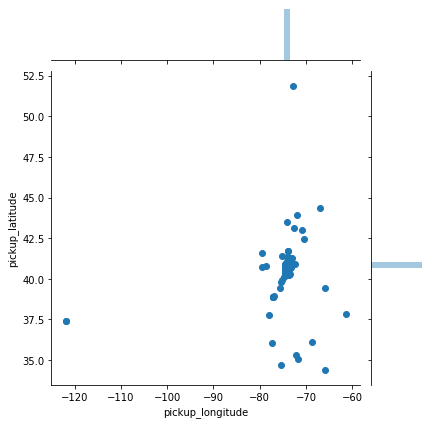

In [12]:
sns.jointplot(data = df, x ='pickup_longitude', y = 'pickup_latitude')
plt.show()

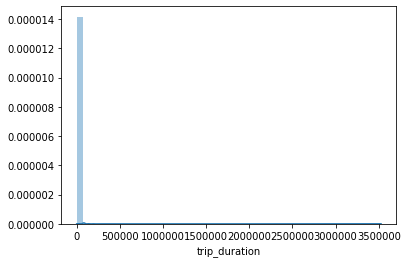

In [13]:
sns.distplot(df['trip_duration'], bins = 50)
plt.show()

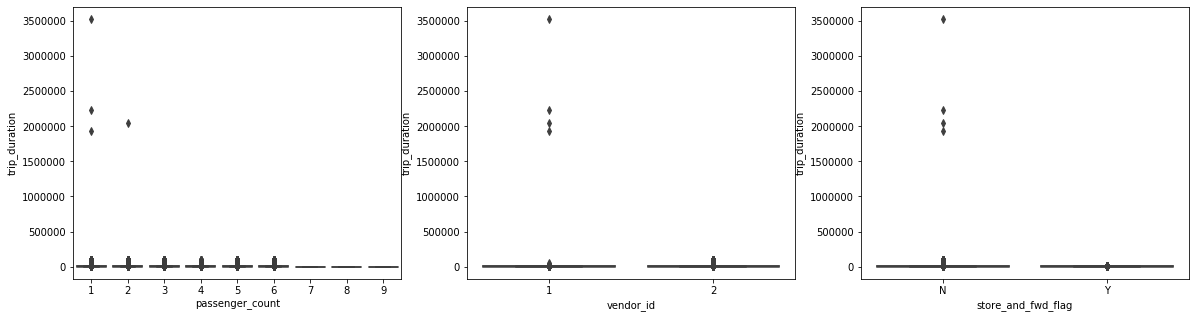

In [14]:
fig, axes = plt.subplots(ncols=3, figsize = (20,5))
sns.boxplot(data = df, x='passenger_count', y='trip_duration', ax = axes[0])
sns.boxplot(data = df, x='vendor_id', y='trip_duration', ax = axes[1])
sns.boxplot(data = df, x='store_and_fwd_flag', y='trip_duration', ax = axes[2])

## 4. Tratamento de Outliers

A técnica utilizada para a remoção foi dropar os dados fora do intervalo de 3 desvios padrões ao redor da média.

In [15]:
# remoção de outliers

columns = df[['passenger_count','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','trip_duration']]

for feature in columns:
    mean = np.mean(df[feature])
    std = np.std(df[feature])
    df = df[df[feature] < (mean + 3*std)]
    df = df[df[feature] > (mean - 3*std)]

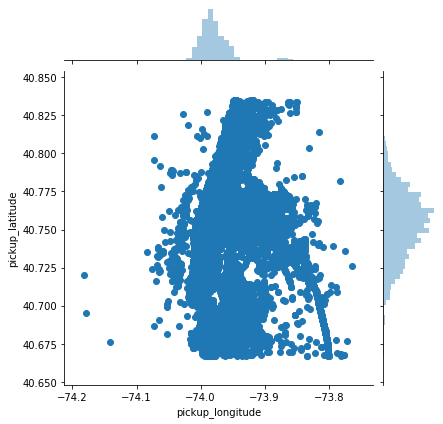

In [16]:
sns.jointplot(data = df, x ='pickup_longitude', y = 'pickup_latitude')
plt.show()

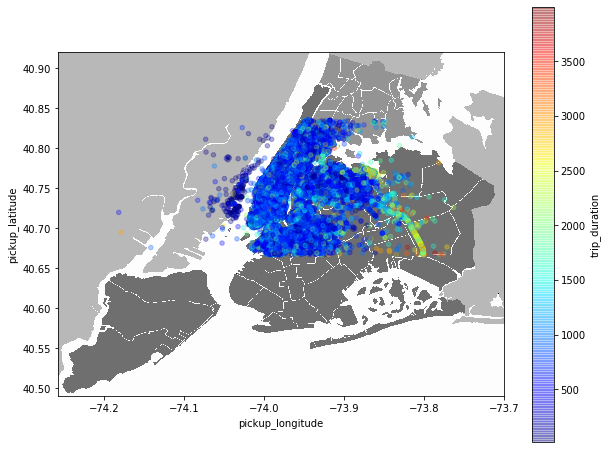

In [17]:
plt.figure(figsize=(10,8))
img = plt.imread('NY.png',0)

plt.imshow(img,zorder=0,extent=[-74.258, -73.7, 40.49,40.92])
ax=plt.gca()

df[df['trip_duration'] < 4000].plot(kind='scatter', x = 'pickup_longitude',y='pickup_latitude',
        c = 'trip_duration',cmap=plt.get_cmap('jet'), colorbar=True,alpha = 0.3,zorder=5, ax = ax)
plt.show()

Aqui podemos ver que agora o nosso dataset possui somente corridas dentro de NY. As de maior duração são as que tiveram início longe de Manhattan, centro comercial da cidade. Algumas corridas aparentemente começaram dentro do mar, mas dropar esses dados fica de dever de casa para quem for praticar com os dados dessa competição.

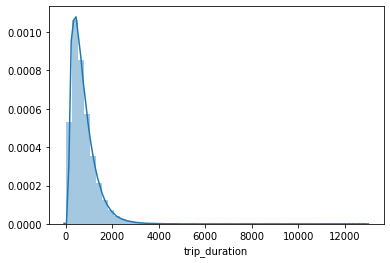

In [18]:
sns.distplot(df['trip_duration'], bins = 50)
plt.show()

Na distribuição agora vemos que as corridas mais longas estão na faixa de 12000 segundos, aproximadamente 3 horas e meia. O que é bem plausível de ter acontecido em uma cidade como NY. E abaixo os violinplots já nos adiantam que não existe grande correlação entre essas 3 features e a duração da viagem. Poderemos conferir isso nos próximos passos.

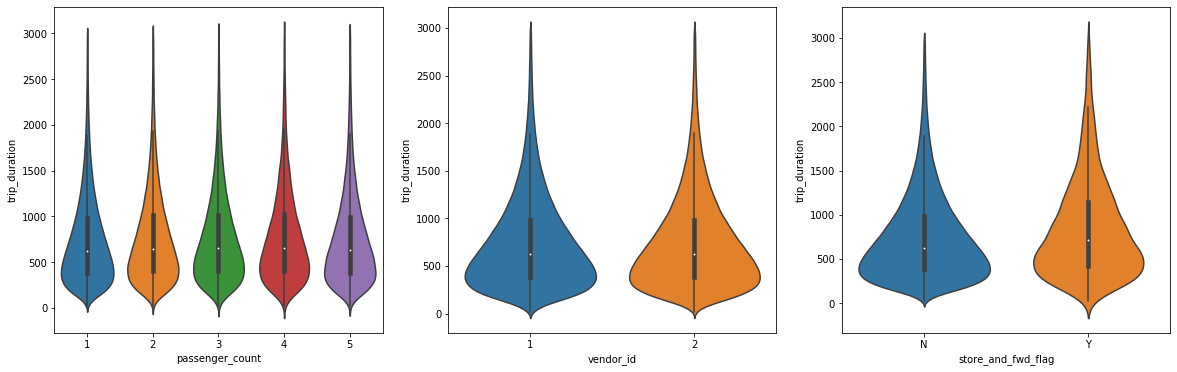

In [19]:
# viagens com duração menor que 3000s

fig, axes = plt.subplots(ncols=3, figsize = (20,6))
sns.violinplot(data = df[df['trip_duration'] < 3000], x='passenger_count', y='trip_duration', ax = axes[0])
sns.violinplot(data = df[df['trip_duration'] < 3000], x='vendor_id', y='trip_duration', ax = axes[1])
sns.violinplot(data = df[df['trip_duration'] < 3000], x='store_and_fwd_flag', y='trip_duration', ax = axes[2])

# 5. Baseline

A Baseline é o resultado de uma modelagem muito simples, que serve de referência para os próximos modelos que forem testados. A ideia da Baseline é ser o limite inferior do que você busca para o projeto, ou seja: para um resultado ser considerado deve ser no mínimo melhor que a Baseline. Neste exemplo a Baseline é uma Random Forest com somente as features numéricas: vendor_id, passenger_count e as latitudes e longitudes.

Por fins de praticidade eu utilizei uma sample aleatória de 5% do dataset total, pois a partir deste momento são feitos alguns testes com os algoritmos de machine learning, e, como estamos lidando com um dataset de mais de 1 milhão de entradas, os tempos de processamento seriam muito longos. Mas é claro que, se o objetivo fosse obter a melhor pontuação no Kaggle, o ideal seria trabalhar integralmente com todo o dataset. Não é o nosso caso.

In [20]:
df_sample = df.sample(frac=0.05, random_state = 42)
df_sample.shape

(66009, 9)

A métrica utilizada foi o RMSE (root-mean-square deviation), mas isso fica a critério. Acredito que quanto mais métricas utilizadas na análise, melhor.

In [21]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X = df_sample.drop(['trip_duration','pickup_datetime','store_and_fwd_flag'], 1)
y = df_sample['trip_duration']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.33, random_state = 42)

rf = RandomForestRegressor(n_jobs = -1)
rf.fit(X_train, y_train)
pred = rf.predict(X_val)

np.sqrt(mean_squared_error(pred, y_val))

336.0091608896725

## 6. Feature Engineering

Aqui é onde grande parte da arte costuma acontecer, e a partir daqui é importante aplicar as transformações tanto no dataset de treino quanto no de teste. Transformei a feature pickup_datetime em uma série de outras features: horário, dia do mês, semana do ano, dia da semana, mês e dia do ano. As possibilidades são muitas, poderíamos considerar dias chuvosos, feriados, eventos importantes, etc. E a maioria desse tipo de dado pode ser encontrado em datasets upados por usuários no próprio Kaggle.

Outra observação importante é que, caso forem usados modelos que dependem de distância entre os pontos, aqui é recomendável normalizar os dados. Neste caso não é necessário pois os modelos validados são tree-based, portanto são robustos neste sentido.

In [22]:
# train
df['pickup_time'] = df['pickup_datetime'].dt.hour + (df['pickup_datetime'].dt.minute)/60
df['pickup_dayofmonth'] = df['pickup_datetime'].dt.day
df['pickup_weekofyear'] = df['pickup_datetime'].dt.weekofyear
df['pickup_dayofweek'] = df['pickup_datetime'].dt.dayofweek
df['pickup_month'] = df['pickup_datetime'].dt.month
df['pickup_dayofyear'] = df['pickup_datetime'].dt.dayofyear

#test
df_test['pickup_time'] = df_test['pickup_datetime'].dt.hour + (df['pickup_datetime'].dt.minute)/60
df_test['pickup_dayofmonth'] = df_test['pickup_datetime'].dt.day
df_test['pickup_weekofyear'] = df_test['pickup_datetime'].dt.weekofyear
df_test['pickup_dayofweek'] = df_test['pickup_datetime'].dt.dayofweek
df_test['pickup_month'] = df_test['pickup_datetime'].dt.month
df_test['pickup_dayofyear'] = df_test['pickup_datetime'].dt.dayofyear

O pacote geopy possui funções que calculam distância entre duas coordenadas, e um dos métodos é o geodesic. Com isso a feature distance foi criada:

In [23]:
from geopy.distance import geodesic

#train
df['distance'] = df.apply(
    (lambda row: geodesic(
        (row['pickup_latitude'], row['pickup_longitude']),
        (row['dropoff_latitude'], row['dropoff_longitude'])
    ).kilometers),
    axis=1
)

#test
df_test['distance'] = df_test.apply(
    (lambda row: geodesic(
        (row['pickup_latitude'], row['pickup_longitude']),
        (row['dropoff_latitude'], row['dropoff_longitude'])
    ).kilometers),
    axis=1
)

Os algoritmos não se dão bem com dados no formato string, então por último foi utilizado o get_dummies na store_and_fwd_flag.

In [24]:
df = pd.get_dummies(df)
df_test = pd.get_dummies(df_test, columns = ['store_and_fwd_flag'])

## 7. Correlação e Feature Importance

Esta etapa tem uma dupla importância. Além de nos permitir escolher as melhores features para usar no nosso modelo, nos faz compreender melhor nossos dado, suas correlações e como elas de fato afetam o algoritmo, o que é muito importante para apresentações, principalmente quando lidamos com pessoas que não são da área. Neste caso é interessante reparar a baixa correlação da pickup_time com a variável target, mas alta importância no algoritmo.

Foi utilizada a RandomForest, novamente, para calcular as feature importances.

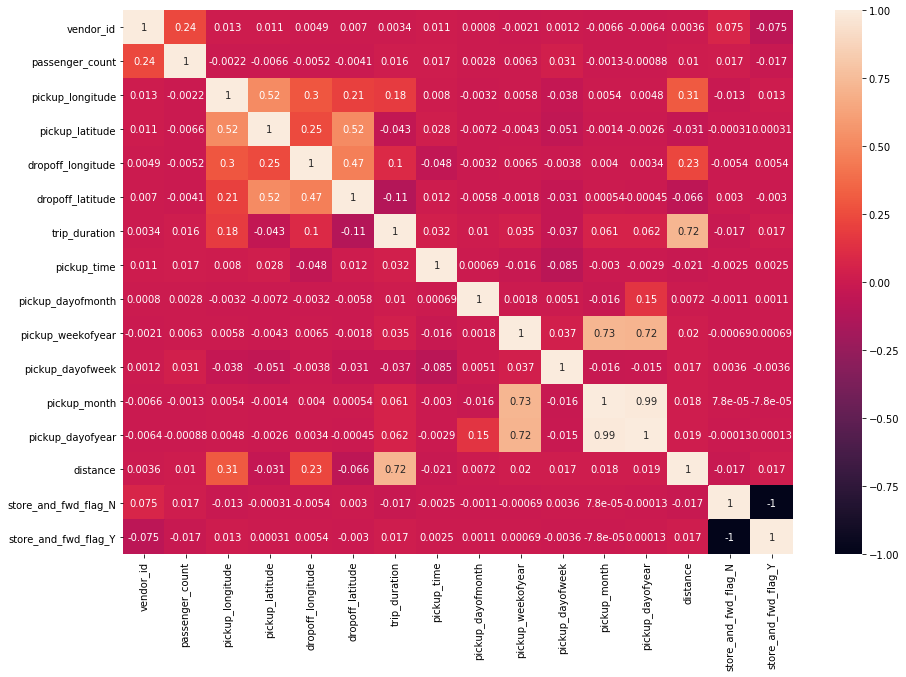

In [25]:
plt.figure(figsize = (15,10))
sns.heatmap(df.corr(), annot = True)

In [26]:
df_sample = df.sample(frac=0.05, random_state = 42)
df_sample.shape

(66009, 17)

In [27]:
X = df_sample.drop(['trip_duration','pickup_datetime'],1)
y = df_sample['trip_duration']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.33, random_state = 42)

rf = RandomForestRegressor(n_jobs = -1)
rf.fit(X_train, y_train)
pred = rf.predict(X_val)

np.sqrt(mean_squared_error(pred, y_val))

291.98132033573853

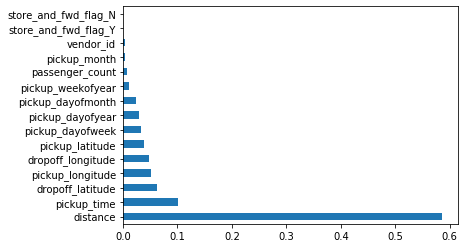

In [28]:
feat_importances = pd.Series(rf.feature_importances_, index= X.columns)
feat_importances.nlargest(15).plot(kind='barh')
plt.show()

O modelo melhorou ligeiramente utilizando as 10 features de maior importância. Mesmo não sendo uma diferença significativa, nos poupa tempo de processamento:

In [29]:
features = feat_importances.sort_values(ascending = False).index[:10]
features

Index(['distance', 'pickup_time', 'dropoff_latitude', 'pickup_longitude',
       'dropoff_longitude', 'pickup_latitude', 'pickup_dayofweek',
       'pickup_dayofyear', 'pickup_dayofmonth', 'pickup_weekofyear'],
      dtype='object')

In [30]:
X = df_sample[features]
y = df_sample['trip_duration']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.33, random_state = 42)

rf = RandomForestRegressor(n_jobs = -1)
rf.fit(X_train, y_train)
pred = rf.predict(X_val)

np.sqrt(mean_squared_error(pred, y_val))

291.58608317100527

## 8. Hiperparametrização e escolha do modelo

Finalizando a Pipeline, nesta etapa podem ser testados quantos modelos forem de interesse com o objetivo de obter as melhores métricas, mas com atenção ao overfit.

Utilizei o Random Search para buscar os melhores parâmetros da Random Forest e do XGboost. Considerando somente uma métrica o XGBoost performou melhor, e provavelmente seria o escolhido para entrar em produção.

In [31]:
from sklearn.model_selection import RandomizedSearchCV
rf = RandomForestRegressor()

n_estimators = [int(x) for x in np.linspace(start = 100, stop = 500, num = 5)]
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

tree_cv = RandomizedSearchCV(rf, random_grid, cv=3, n_jobs = -1, n_iter = 10)

In [36]:
tree_cv.fit(X,y)
model = tree_cv.best_estimator_
pred = model.predict(X_val)

print("Tuned Decision Tree Parameters: {}".format(tree_cv.best_params_))
print("Best RMSE is {}".format(np.sqrt(mean_squared_error(pred, y_val))))

Tuned Decision Tree Parameters: {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_depth': 20, 'bootstrap': True}
Best RMSE is 185.82912175585145


In [37]:
import xgboost as xgb

XGB = xgb.XGBRegressor()

param_grid = {
'silent': [False],
'max_depth': [6, 10, 15, 20],
'learning_rate': [0.001, 0.01, 0.1, 0.2, 0,3],
'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
'colsample_bytree': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
'colsample_bylevel': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
'min_child_weight': [0.5, 1.0, 3.0, 5.0, 7.0, 10.0],
'gamma': [0, 0.25, 0.5, 1.0],
'reg_lambda': [0.1, 1.0, 5.0, 10.0, 50.0, 100.0],
'n_estimators': [100]}

xgb_cv = RandomizedSearchCV(XGB, param_grid, cv=3, n_jobs = -1, n_iter = 30)

In [38]:
xgb_cv.fit(X,y)
model = xgb_cv.best_estimator_
pred = model.predict(X_val)

print("Tuned Decision Tree Parameters: {}".format(xgb_cv.best_params_))
print("Best RMSE is {}".format(np.sqrt(mean_squared_error(pred, y_val))))

[19:54:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Tuned Decision Tree Parameters: {'subsample': 0.5, 'silent': False, 'reg_lambda': 100.0, 'n_estimators': 100, 'min_child_weight': 3.0, 'max_depth': 10, 'learning_rate': 0.2, 'gamma': 0.5, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.8}
Best RMSE is 231.6011549146724


In [ ]:
model = tree_cv.best_estimator_

pred = model.predict(df_test[features])
submission = pd.DataFrame({'id': df_test.id, 'trip_duration': pred})
submission.to_csv('submission.csv', index=False)